In [1]:
import numpy as np
import cv2
from Utils.ImageUtils import *
from Utils.Triangulation import *
from Utils.FundamentalEssentialMatrix import *
from Utils.MiscUtils import *
from Utils.GeometryUtils import *
from Utils.MathUtils import *

from matplotlib import pyplot as plt
import math
from tqdm import *

# K1 = np.array([[5299.313, 0, 1263.818], [0, 5299.313, 977.763], [0, 0, 1]])
# K2 = np.array([[5299.313, 0, 1438.004], [0, 5299.313, 977.763], [0, 0, 1]])
# baseline=177.288
# f = K1[0,0]

In [3]:
folder_name = "/home/sakshi/courses/ENPM673/project3_sakshi/Data/Project 3/Dataset 1"

dataset_number = 1
if dataset_number == 1:
    K1 = np.array([[5299.313, 0, 1263.818], [0, 5299.313, 977.763], [0, 0, 1]])
    K2 = np.array([[5299.313, 0, 1438.004], [0, 5299.313, 977.763], [0, 0, 1]])
    baseline=177.288
    f = K1[0,0]

elif dataset_number == 2:
    K1 = np.array([[4396.869, 0, 1353.072], [0, 4396.869, 989.702], [0, 0, 1]])
    K2 = np.array([[4396.869, 0, 1538.86], [0, 4396.869, 989.702], [0, 0, 1]])
    baseline=144.049
    f = K1[0,0]

elif dataset_number == 3:
    K1 = np.array([[5806.559, 0, 1429.219], [0, 5806.559, 993.403], [0, 0, 1]])
    K2 = np.array([[5806.559, 0, 1543.51], [0, 5806.559, 993.403], [0, 0, 1]])
    baseline=174.019
    f = K1[0,0]

else:
    print("invalid datset number")


images = readImageSet(folder_name, 2)
# find the keypoints and descriptors with SIFT
sift = cv2.xfeatures2d.SIFT_create()
image0 = images[0].copy()
image1 = images[1].copy()

image0_gray = cv2.cvtColor(image0, cv2.COLOR_BGR2GRAY) 
image1_gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)


kp1, des1 = sift.detectAndCompute(image0_gray, None)
kp2, des2 = sift.detectAndCompute(image1_gray, None)

bf = cv2.BFMatcher()
matches = bf.match(des1,des2)
matches = sorted(matches, key = lambda x :x.distance)
chosen_matches = matches[0:100]

img3 = cv2.drawMatches(image0, kp1, image1, kp2, chosen_matches, images[0], flags=2)
displaySaveImage(img3, "../Results/matches" + str(dataset_number)+ ".png")

matched_pairs = siftFeatures2Array(chosen_matches, kp1, kp2)

F_best, matched_pairs_inliers = getInliers(matched_pairs)
showMatches(image0, image1, matched_pairs_inliers, (0,0,255), "../Results/matches_inlier3" + str(dataset_number)+ ".png")
E = getEssentialMatrix(K1, K2, F_best)


Reading images from  /home/sakshi/courses/ENPM673/project3_sakshi/Data/Project 3/Dataset 1


## extract Pose and Get 3D points


In [4]:

R2, C2 = ExtractCameraPose(E)
pts3D_4 = get3DPoints(K1, K2, matched_pairs_inliers, R2, C2)

## reproject 3D points on image

In [5]:
R1 = np.identity(3)
C1 = np.zeros((3,1))
x, y = reproject3DPoints(R2, C2, K2, pts3D_4)
im = image1.copy()
for i in range(matched_pairs_inliers.shape[0]):

    x1, y1 = x[i], y[i]
    x2, y2 = matched_pairs_inliers[i, 2], matched_pairs_inliers[i, 3]
    cv2.circle(im, (int(x1), int(y1)), 10, (0,0,255), 10)
    cv2.circle(im, (int(x2), int(y2)), 3, (0,255,0), 3)

cv2.imshow("im", im)
cv2.waitKey() 
cv2.destroyAllWindows()

## plot 3D points and select R, C

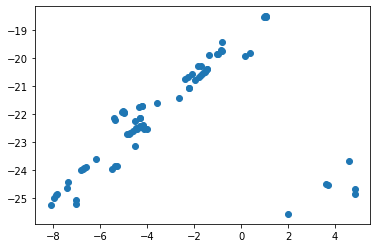

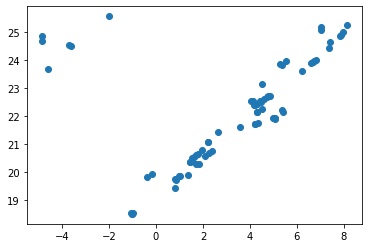

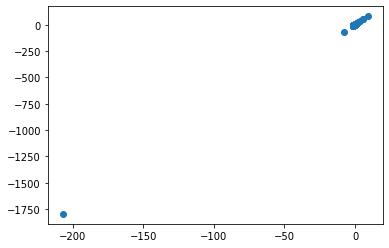

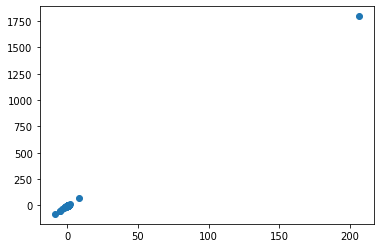

In [6]:
z_count1 = []
z_count2 = []

for i in range(len(pts3D_4)):
    pts3D = pts3D_4[i]
    pts3D = pts3D/pts3D[3, :]
    x = pts3D[0,:]
    y = pts3D[1, :]
    z = pts3D[2, :]    

    z_count2.append(getPositiveZCount(pts3D, R2[i], C2[i]))
    z_count1.append(getPositiveZCount(pts3D, R1, C1))

    # fig = plt.figure()
    # ax = plt.axes(projection='3d')
    # ax.scatter(x, y, z, linewidth=0.5)

    fig = plt.figure()
    plt.scatter(x,z)
    plt.savefig("../Results/" + str(i) + str(dataset_number)+ ".png")

z_count1 = np.array(z_count1)
z_count2 = np.array(z_count2)

count_thresh = int(pts3D_4[0].shape[1] / 2)
idx = np.intersect1d(np.where(z_count1 > count_thresh), np.where(z_count2 > count_thresh))
R2_ = R2[idx[0]]
C2_ = C2[idx[0]]
X_ = pts3D_4[idx[0]]
X_ = X_/X_[3,:]



In [7]:
R2_, C2_

(array([[ 9.99984819e-01, -1.22707959e-04, -5.50874983e-03],
        [ 1.19807354e-04,  9.99999854e-01, -5.26871988e-04],
        [ 5.50881367e-03,  5.26204001e-04,  9.99984688e-01]]),
 array([ 0.99620267, -0.01358653, -0.08599793]))

## Plot epilines

In [8]:
set1, set2 = matched_pairs_inliers[:,0:2], matched_pairs_inliers[:,2:4]
lines1, lines2 = getEpipolarLines(set1, set2, F_best, image0, image1, "../Results/epilines" + str(dataset_number)+ ".png", False)

## Image Rectification

In [9]:
h1, w1 = image0.shape[:2]
h2, w2 = image1.shape[:2]
_, H1, H2 = cv2.stereoRectifyUncalibrated(np.float32(set1), np.float32(set2), F_best, imgSize=(w1, h1))

img1_rectified = cv2.warpPerspective(image0, H1, (w1, h1))
img2_rectified = cv2.warpPerspective(image1, H2, (w2, h2))

set1_rectified = cv2.perspectiveTransform(set1.reshape(-1, 1, 2), H1).reshape(-1,2)
set2_rectified = cv2.perspectiveTransform(set2.reshape(-1, 1, 2), H2).reshape(-1,2)

img1_rectified_draw = img1_rectified.copy()
img2_rectified_draw = img2_rectified.copy()

for i in range(set1_rectified.shape[0]):
    cv2.circle(img1_rectified_draw, (int(set1_rectified[i,0]),int(set1_rectified[i,1])), 10, (0,0,255), -1)
    cv2.circle(img2_rectified_draw, (int(set2_rectified[i,0]),int(set2_rectified[i,1])), 10, (0,0,255), -1)
displaySaveImage(img1_rectified_draw, "../Results/imgRectified1_"+ str(dataset_number)+ ".png")
displaySaveImage(img2_rectified_draw, "../Results/imgRectified2_" + str(dataset_number)+ ".png")


In [10]:
H1, H2

(array([[ 1.20862669e-03,  1.08655103e-05, -1.90189222e-01],
        [ 3.56993397e-05,  1.16778466e-03, -5.81879582e-02],
        [ 2.01132725e-08, -1.78077265e-10,  1.13506978e-03]]),
 array([[ 1.02422373e+00, -1.35186044e-02, -2.26175750e+01],
        [ 2.95351236e-02,  9.99697271e-01, -4.38215347e+01],
        [ 1.62723056e-05, -2.14776182e-07,  9.75904811e-01]]))

## get rectified epilines

In [11]:
H2_T_inv =  np.linalg.inv(H2.T)
H1_inv = np.linalg.inv(H1)
F_rectified = np.dot(H2_T_inv, np.dot(F_best, H1_inv))

lines1_rectified, lines2_recrified = getEpipolarLines(set1_rectified, set2_rectified, F_rectified, img1_rectified, img2_rectified, "../Results/RectifiedEpilines_" + str(dataset_number)+ ".png", True)

## Find Correspondance

In [12]:
# search_distance = 50
img1_rectified_reshaped = cv2.resize(img1_rectified, (int(img1_rectified.shape[1] / 4), int(img1_rectified.shape[0] / 4)))
img2_rectified_reshaped = cv2.resize(img2_rectified, (int(img2_rectified.shape[1] / 4), int(img2_rectified.shape[0] / 4)))

img1_rectified_reshaped = cv2.cvtColor(img1_rectified_reshaped, cv2.COLOR_BGR2GRAY)
img2_rectified_reshaped = cv2.cvtColor(img2_rectified_reshaped, cv2.COLOR_BGR2GRAY)

window = 11


In [13]:

left_array, right_array = img1_rectified_reshaped, img2_rectified_reshaped
left_array = left_array.astype(int)
right_array = right_array.astype(int)
if left_array.shape != right_array.shape:
    raise "Left-Right image shape mismatch!"
h, w = left_array.shape
disparity_map = np.zeros((h, w))


# Go over each pixel position
block_left_array_2D = []
block_right_array_2D = []
x_new = w - (2 * window)

for y in tqdm(range(window, h-window)):
    block_left_array = []
    block_right_array = []
    for x in range(window, w-window):
        block_left = left_array[y:y + window,
                                x:x + window]
        block_left_array.append(block_left.flatten())

        block_right = right_array[y:y + window,
                                x:x + window]
        block_right_array.append(block_right.flatten())

    # block_left_array_2D.append(block_left_array)
    # block_right_array_2D.append(block_right_array)


    block_left_array = np.array(block_left_array)
    block_left_array = np.repeat(block_left_array[:, :, np.newaxis], x_new, axis=2)

    block_right_array = np.array(block_right_array)
    block_right_array = np.repeat(block_right_array[:, :, np.newaxis], x_new, axis=2)
    block_right_array = block_right_array.T

    abs_diff = np.abs(block_left_array - block_right_array)
    sum_abs_diff = np.sum(abs_diff, axis = 1)
    idx = np.argmin(sum_abs_diff, axis = 0)
    disparity = np.abs(idx - np.linspace(0, x_new, x_new, dtype=int)).reshape(1, x_new)
    disparity_map[y, 0:x_new] = disparity 






100%|██████████| 480/480 [06:28<00:00,  1.23it/s]


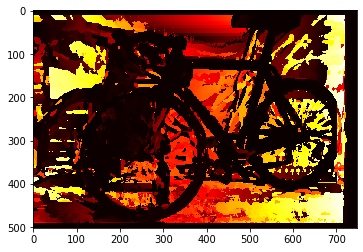

In [14]:
disparity_map_int = np.uint8(disparity_map * 255 / np.max(disparity_map))
plt.imshow(disparity_map_int, cmap='hot', interpolation='nearest')
plt.savefig('depth_image.png')
plt.show()

In [29]:

f = K1[0,0]
depth = (baseline * f) / (disparity_map + 1e-10)
depth[depth > 100000] = 100000

In [30]:
np.min(depth)

1306.6823409511396

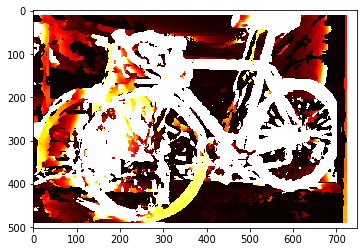

In [31]:
depth_map = np.uint8(depth * 255 / np.max(depth))
plt.imshow(depth_map, cmap='hot', interpolation='nearest')
plt.imshow(depth_map, cmap='gray', interpolation='nearest')
# plt.savefig('depth_image.png')
plt.show()